## Sklearn k-means example

### Imports

In [222]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [309]:
import numpy as np
import random
from time import time

In [310]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [311]:
import sklearn as sk
from sklearn import datasets
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import metrics

In [312]:
from sklearn.metrics.cluster import completeness_score
print(completeness_score([0, 0, 1, 1], [1, 1, 0, 0]))

1.0


---
### Functions

In [227]:
def create_bag(data, bag_size=1.0, with_repeats=True):
    data_length = data.shape[0]
    bag_length = int(data_length*bag_size)
    
    bag = np.empty((0,data.shape[1]))
    if with_repeats:
        # just draw randomly
#         print('Bagging with repeats')
        for i in range(0, bag_length):
            r = np.random.randint(0, data_length-1)
            bag = np.vstack([bag, data[r]])
            
        return bag
        
    else:
        # remove values from original set after selected
#         print('Bagging with no repeats')
        a = np.arange(0, data.shape[0])
        sample = np.random.choice(a, bag_length)
        
        return data[sample, :]

In [228]:
def print_class_ratios(y):
    l = len(y)
    
    unique, counts = np.unique(y, return_counts=True)
    print('Class \t Count \t Percentage')
    for i in range(0, len(unique)):
        perc = 100 * counts[i]/l
        print('{} \t {} \t {:.2f} %'.format(int(unique[i]), counts[i], perc))

In [229]:
def explain_data(X, y=None, problem_type='classification'):
    print('X.shape: {}'.format(X.shape))
    print('X first record: {}'.format(X[0]))
    print()
    
    if y is not None:
        print('y.shape: {}'.format(y.shape))
        print('y first record: {}'.format(y[0]))
        print()
        
        if problem_type == 'classification':
            print_class_ratios(y)

In [434]:
def calculate_centroids(data, n_classes=2):
    """
    Takes a numpy array of shape (X,3) with the 3 columns being
    x-coord, y-coord, label. 
    """
    
    centroids = np.zeros((n_classes, 2))
    counts = np.zeros((n_classes))
    
    for i in range(data.shape[0]):
        current_class = int(data[i, -1])
        counts[current_class] += 1
        
        centroids[current_class, 0] += data[i, 0]
        centroids[current_class, 1] += data[i, 1]
        
    for i in range(0, n_classes):
        centroids[i, :] = centroids[i, :] / counts[i]
    
#     print(centroids)
    
    return centroids

In [231]:
def create_bagged_classifier_list(data, labels, n_iter=10):
    labels = np.reshape(labels, (labels.shape[0], 1))
    full_set = np.hstack([data, labels])
    clf_config = {
        'algorithm' : 'auto',
        'copy_x' : True,
        'init' : 'k-means++',
        'max_iter' : 300,
        'n_clusters' : 10,
        'n_init' : 1,
        'n_jobs' : None,
        'precompute_distances' : 'auto',
        'random_state' : None,
        'tol' : 0.0001,
        'verbose' : 0
    }
    
    classifiers = []
    bags = []
    predicted_labels = []
    for i in range(0, n_iter):
        # Ensure all models get trained in the same way
        np.random.seed(42)
        
        # Create n_iter number of untrained k-means classifiers with same hyperparameters
        classifiers.append(KMeans(algorithm=clf_config['algorithm'], copy_x=clf_config['copy_x'],
                                  init=clf_config['init'], max_iter=clf_config['max_iter'], n_clusters=clf_config['n_clusters'],
                                  n_init=clf_config['n_init'], n_jobs=clf_config['n_jobs'],
                                  precompute_distances=clf_config['precompute_distances'], 
                                  random_state=clf_config['random_state'], tol=clf_config['tol'],
                                  verbose=clf_config['verbose']))
        
        # Create n_iter number of bags from the original data
        bags.append(create_bag(full_set))
        
        # Split the data back into features/labels
        features = bags[i][:,:-1]
        labels = bags[i][:,-1]
        
        # Train classifier on one of the bags
        classifiers[i].fit(features)
        
    return classifiers

### Functions end              
---

### ************ ************************

### **Gaussian dist**

#### Create data points

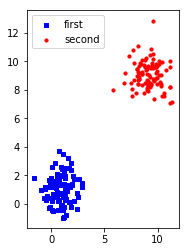

In [569]:
np.random.seed(42)

cluster_1 = np.random.multivariate_normal([1,1], [[1,0],[0,1]], 100)
cluster_2 = np.random.multivariate_normal([9,9], [[1,0],[0,1]], 100)

fig = plt.figure()
ax1 = fig.add_subplot(121)

ax1.scatter(cluster_1[:,0], cluster_1[:,1], s=10, c='b', marker="s", label='first')
ax1.scatter(cluster_2[:,0], cluster_2[:,1], s=10, c='r', marker="o", label='second')
ax1.legend(loc='upper left');
plt.show()

#### Add labels

In [570]:
# Assign labels to the 3rd columns
cluster_1 = np.hstack([cluster_1, np.zeros((cluster_1.shape[0],1))])
cluster_1[:,-1] = 0
cluster_2 = np.hstack([cluster_2, np.zeros((cluster_2.shape[0],1))])
cluster_2[:,-1] = 1

# Concatenate the arrays together
both_clusters = np.vstack([cluster_1, cluster_2])
both_clusters.shape

(200, 3)

In [571]:
data = both_clusters[:,:2]
labels = both_clusters[:, -1]
explain_data(data, labels)

X.shape: (200, 2)
X first record: [1.49671415 0.8617357 ]

y.shape: (200,)
y first record: 0.0

Class 	 Count 	 Percentage
0 	 100 	 50.00 %
1 	 100 	 50.00 %


#### Train / test split

In [572]:
# Train test split for gaussian data
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(data, labels, test_size=0.3, random_state=42)

print('Training example \t\t Label')
for i in range(0,5):
    print('{} :\t {}'.format(X_train[i], y_train[i]))

Training example 		 Label
[9.41293145 8.43627545] :	 1.0
[1.17318093 1.38531738] :	 0.0
[-0.10633497 -0.19620662] :	 0.0
[0.45561728 1.11092259] :	 0.0
[1.36139561 2.53803657] :	 0.0


#### Fit model

In [573]:
og_clf = KMeans(init='k-means++', n_clusters=2, n_init=10)
og_clf_fit = og_clf.fit(X_train)
X_train_pred = og_clf.fit_predict(X_train)

#### Train "accuracy"

In [574]:
X_train_pred

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0], dtype=int32)

In [575]:
og_train_acc = metrics.accuracy_score(y_true=y_train, y_pred=X_train_pred, normalize=True, sample_weight=None)
print('OG training accuracy: {:.3f} %'.format(og_train_acc*100))

OG training accuracy: 0.000 %


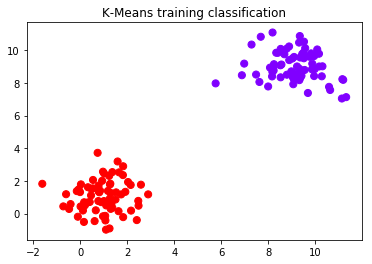

In [576]:
plt.title('K-Means training classification')
plt.scatter(X_train[:, 0], X_train[:, 1], c=X_train_pred, s=50, cmap='rainbow')

#### Test "accuracy"

In [577]:
predictions = og_clf.predict(X_test)
og_test_acc = metrics.accuracy_score(y_true=y_test, y_pred=predictions, normalize=True, sample_weight=None)
print('OG test accuracy: {:.3f} %'.format(og_test_acc*100))

OG test accuracy: 0.000 %


#### Centroids

In [578]:
# Prepare data to calculate centroids with `calculate_centroids` function
data = np.hstack([X_train, y_train.reshape((y_train.shape[0], 1))])
print(data.shape)
print(data[0:5])

(140, 3)
[[ 9.41293145  8.43627545  1.        ]
 [ 1.17318093  1.38531738  0.        ]
 [-0.10633497 -0.19620662  0.        ]
 [ 0.45561728  1.11092259  0.        ]
 [ 1.36139561  2.53803657  0.        ]]


In [579]:
# Cluster centres of fitted (training) data vs true values 
train_centres = calculate_centroids(data)
fitted_centres = og_clf_fit.cluster_centers_
print('True centroids: \n{}'.format(train_centres))
print('Fitted centroids: \n{}'.format(fitted_centres))

True centroids: 
[[0.95265961 1.06384253]
 [9.11918651 9.01275567]]
Fitted centroids: 
[[9.11918651 9.01275567]
 [0.95265961 1.06384253]]


#### Plot classes

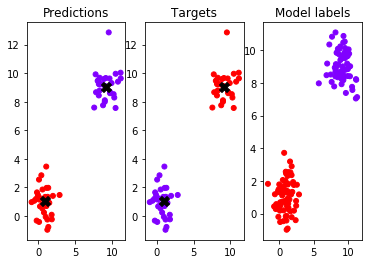

In [580]:
plt.subplot(1,3,1)
plt.title('Predictions')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, s=25, cmap='rainbow')
plt.scatter(fitted_centres[:, 0], fitted_centres[:,1], s=100, c='k', marker="X")

plt.subplot(1,3,2)
plt.title('Targets')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=25, cmap='rainbow')
plt.scatter(train_centres[:, 0], train_centres[:,1], s=100, c='k', marker="X")

plt.subplot(1,3,3)
plt.title('Model labels')
plt.scatter(X_train[:, 0], X_train[:, 1], c=og_clf.labels_, s=25, cmap='rainbow')

In [581]:
print('predictions: {}'.format(predictions))
print('y_test: {}'.format(y_test))

predictions: [1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0
 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1]
y_test: [0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.]


###  Do all the things

In [518]:
def do_all_the_things(clusters: list, test_set_size: float=0.3, km_model:sk.cluster.k_means_.KMeans=None):
    """
    This functions will encapsulate basically all the code above so that it will train and measure a k-means classifier just by giving it a list of clustered points.
    The clustered points at this point have to be 2d, but there can be any number of clusters in the list.
    
    Parameters: 
    clusters (list): A list of clustered points. The clustered points are expected to be numpy arrays of shape (n,2), where n in the number of points.
    test_set_size (float): A float between 0 and 1 indicating the size, in percentage, of the test set (e.g. 0.3 = 30%).
    km_model (sklearn.cluster.k_means_.KMeans): A Sklearn k-means model. You can pass you in if you want to override the default.
  
    Returns: 
    We shall see...
    """
    # Assign labels to the 3rd columns
    print('Adding labels...\n')
    for i in range(len(clusters)):
        clusters[i] = np.hstack([clusters[i], np.zeros((clusters[i].shape[0],1))])
        clusters[i][:,-1] = i
        
    # Concatenate the arrays together
    print('Stacking clusters together...\n')
    stacked_cluster = np.empty((0,3))
    for cluster in clusters:
        print('cluster shape: {}'.format(cluster.shape))
        stacked_cluster = np.vstack([stacked_cluster, cluster])
        
    print('Stacked clusters shape: {}\n'.format(stacked_cluster.shape))
    
    data = stacked_cluster[:,:2]
    labels = stacked_cluster[:, -1]
    explain_data(data, labels)
    
    # ------------------------------------
    # Train / Test split
    
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(data, labels, test_size=test_set_size, random_state=42)
    
    if int(test_set_size) == 0:
        print('\nWARNING: test_set_size = 0. No test data will be generated.\n')

    print('Training example \t\t Label')
    for i in range(0,5):
        print('{} :\t {}'.format(X_train[i], y_train[i]))
        
    # ------------------------------------
    #                                  ***
    # Fit the model
    
    if km_model is not None:
        km_clf = km_model
        print('\nUsing user defined k-means model: \n{}\n'.format(km_clf))
    else:
        km_clf = KMeans(init='k-means++', n_clusters=2, n_init=10, random_state=42)
        print('\nUsing default k-means model: \n{}\n'.format(km_clf))
        
    # Fit to the training data
    km_clf = km_clf.fit(X_train)  
    # Get training predictions (clusters)
    X_train_pred = km_clf.predict(X_train)
    
    # ------------------------------------
    # Training "accuracy"
    
    km_train_acc = metrics.accuracy_score(y_true=y_train, y_pred=X_train_pred, normalize=True, sample_weight=None)
    print('\nK-means training accuracy: {:.3f} %'.format(km_train_acc*100))
    
    # ------------------------------------
    # Scoring "accuracy"
    
    predictions = km_clf.predict(X_test)
    km_test_acc = metrics.accuracy_score(y_true=y_test, y_pred=predictions, normalize=True, sample_weight=None)
    print('K-means scoring accuracy: {:.3f} %'.format(km_test_acc*100))
    
    # ------------------------------------
    # Centroids
    
    # Prepare data to calculate centroids with `calculate_centroids` function
    data_train = np.hstack([X_train, y_train.reshape((y_train.shape[0], 1))])
    data_test = np.hstack([X_test, y_test.reshape((y_test.shape[0], 1))])
    
    # Cluster centres of fitted (training) data vs true values 
#     print('\nFitted centroids:')
    fitted_centres = km_clf.cluster_centers_
    print('\nFitted centroids: \n{}'.format(fitted_centres))
    true_centres_train = calculate_centroids(data_train)
    true_centres_test = calculate_centroids(data_test)
    print('True centroids (training set): \n{}'.format(true_centres_train))
    print('True centroids (test set): \n{}'.format(true_centres_test))
    
    # ------------------------------------
    # Plotting the classes
    
    f = plt.figure(figsize=(14,7))
    ax1 = f.add_subplot(221)
    ax2 = f.add_subplot(222)
    ax3 = f.add_subplot(223)
    ax4 = f.add_subplot(224)
    
    ax1.title.set_text('Predictions')
    ax1.scatter(X_test[:, 0], X_test[:, 1], c=predictions, s=25, cmap='rainbow')
    ax1.scatter(fitted_centres[:, 0], fitted_centres[:,1], s=100, c='k', marker="X")

    ax2.title.set_text('Targets')
    ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=25, cmap='rainbow')
    ax2.scatter(true_centres_test[:, 0], true_centres_test[:,1], s=100, c='k', marker="X")

    ax3.title.set_text('Training fit')
    ax3.scatter(X_train[:, 0], X_train[:, 1], c=og_clf.labels_, s=25, cmap='rainbow')
    ax3.scatter(fitted_centres[:, 0], fitted_centres[:,1], s=100, c='k', marker="X")
    
    ax4.title.set_text('Training targets')
    ax4.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=25, cmap='rainbow')
    ax4.scatter(true_centres_train[:, 0], true_centres_train[:,1], s=100, c='k', marker="X")
    
    # Add some padding to subplots
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25)
    
    # Contruct the data dictionary to return
    data_dict = dict({'predictions': predictions,
                      'y_test' : y_test,
                      'trained_labels' : X_train_pred,
                      'y_train' : y_train,
                      'fit_centroids' : fitted_centres,
                      'true_centers_train' : true_centres_train,
                      'true_centres_test' : true_centres_test,
                      'train_acc' : km_train_acc,
                      'test_acc' : km_test_acc,
                      'model' : km_clf})
    
    # Return the results data dictionary
    return data_dict
    

---
#### Cluster group 2
---

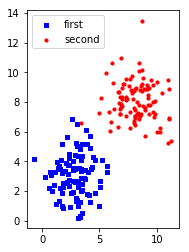

In [531]:
np.random.seed(42)

cluster_1 = np.random.multivariate_normal([3,3], [[2,0],[0,2]], 100)
cluster_2 = np.random.multivariate_normal([8,8], [[2,0],[0,2]], 100)

fig = plt.figure()
ax1 = fig.add_subplot(121)

ax1.scatter(cluster_1[:,0], cluster_1[:,1], s=10, c='b', marker="s", label='first')
ax1.scatter(cluster_2[:,0], cluster_2[:,1], s=10, c='r', marker="o", label='second')
ax1.legend(loc='upper left');
plt.show()

In [532]:
cluster_list = [cluster_1, cluster_2]

Adding labels...

Stacking clusters together...

cluster shape: (100, 3)
cluster shape: (100, 3)
Stacked clusters shape: (200, 3)

X.shape: (200, 2)
X first record: [3.70245989 2.80446475]

y.shape: (200,)
y first record: 0.0

Class 	 Count 	 Percentage
0 	 100 	 50.00 %
1 	 100 	 50.00 %


Training example 		 Label
[8.58397326 7.20277309] :	 1.0
[3.24491481 3.54492106] :	 0.0
[1.43540608 1.30830837] :	 0.0
[2.23012657 3.15686823] :	 0.0
[3.51109057 5.17511217] :	 0.0

Using default k-means model: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


K-means training accuracy: 0.714 %
K-means scoring accuracy: 0.000 %

Fitted centroids: 
[[8.2364466  8.03899271]
 [2.93995208 3.13972997]]
True centroids (training set): 
[[2.93305058 3.09028697]
 [8.16855518 8.01803925]]
True centroids (test set): 
[[2.62181472 2.95424782]
 [8.21274796 8.16790675]]


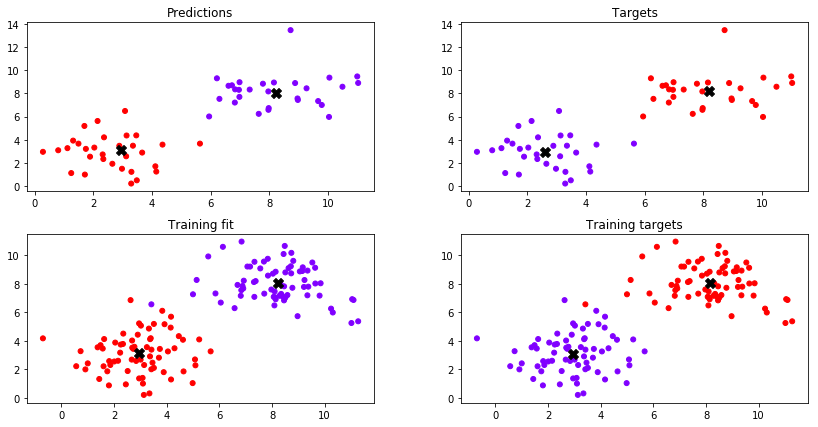

In [533]:
results_2 = do_all_the_things(cluster_list)
results_2['model_name'] = 'k-means_gauss_2'

In [522]:
y_test, predictions = (results['y_test'], results['predictions'])
print('\n{}\n{}\n'.format(y_test, predictions))


[0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.]
[1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1
 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1]



---
#### Cluster group 3
---

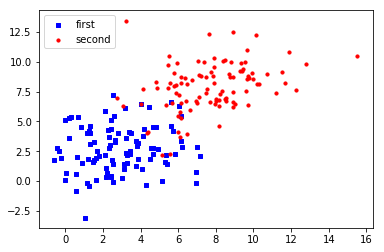

In [528]:
np.random.seed(42)

cluster_1 = np.random.multivariate_normal([3,3], [[4,1],[1,5]], 100)
cluster_2 = np.random.multivariate_normal([8,8], [[5,1],[1,4]], 100)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(cluster_1[:,0], cluster_1[:,1], s=10, c='b', marker="s", label='first')
ax1.scatter(cluster_2[:,0], cluster_2[:,1], s=10, c='r', marker="o", label='second')
ax1.legend(loc='upper left');
plt.show()

In [529]:
cluster_list = [cluster_1, cluster_2]

Adding labels...

Stacking clusters together...

cluster shape: (100, 3)
cluster shape: (100, 3)
Stacked clusters shape: (200, 3)

X.shape: (200, 2)
X first record: [3.40266497 4.1351754 ]

y.shape: (200,)
y first record: 0.0

Class 	 Count 	 Percentage
0 	 100 	 50.00 %
1 	 100 	 50.00 %


Training example 		 Label
[7.71245217 6.60357601] :	 1.0
[3.81857626 2.97664049] :	 0.0
[-0.24990792  1.92588023] :	 0.0
[2.49516261 1.79514772] :	 0.0
[5.85637679 2.24164875] :	 0.0

Using default k-means model: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


K-means training accuracy: 5.714 %
K-means scoring accuracy: 8.333 %

Fitted centroids: 
[[7.91451003 8.21680923]
 [3.14535706 2.80137857]]
True centroids (training set): 
[[3.04088126 2.84282553]
 [7.74735817 7.87143511]]
True centroids (test set): 
[[2.61615935 2.49209924]
 [7.58189567 7.99827402]]


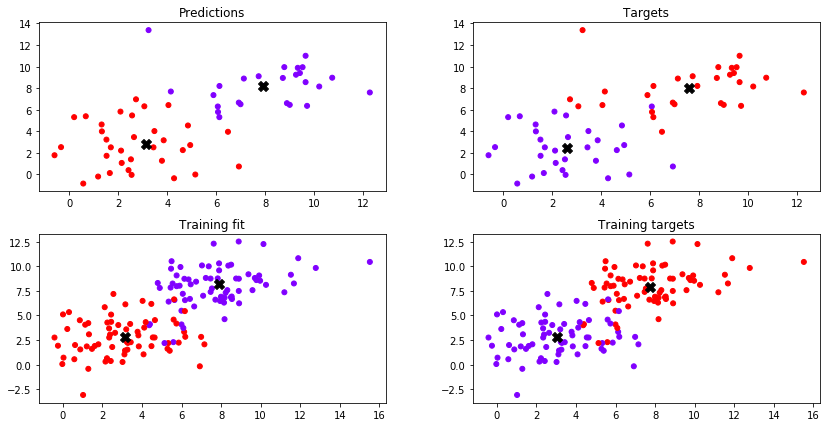

In [530]:
results_3 = do_all_the_things(cluster_list)
results_3['model_name'] = 'k-means_gauss_3'

---
## Metrics

In [566]:
def print_metrics(metrics_list):
    """
    parameter: metrics_list (list): A list of dictionaries containing the following keys: [model_name, model, y_test, predictions]
                                      - len(y_test) must equal len(predictions) for each dict
    """
    
    print('name \t\t\t inertia \t homo \t\t compl \t\t v-meas \t ARI \t\t AMI')
    for result in metrics_list:
        model_name = result['model_name']
        inertia = result['model'].inertia_
        y_test = result['y_test']
        predictions = result['predictions']
        
        print('%-9s \t %i \t\t %.3f \t\t %.3f \t\t %.3f \t\t %.3f \t\t %.3f \t'
                  % (model_name, og_clf.inertia_,
                     metrics.homogeneity_score(y_test, predictions),
                     metrics.completeness_score(y_test, predictions),
                     metrics.v_measure_score(y_test, predictions),
                     metrics.adjusted_rand_score(y_test, predictions),
                     metrics.adjusted_mutual_info_score(y_test,  predictions,
                                                        average_method='arithmetic') ))

#### Construct metrics_list

In [567]:
# Construct metrics_list
metrics_list = [results_2, results_3]

In [568]:
# Print metrics
print_metrics(metrics_list)

name 			 inertia 	 homo 		 compl 		 v-meas 	 ARI 		 AMI
k-means_gauss_2 	 276 		 1.000 		 1.000 		 1.000 		 1.000 		 1.000 	
k-means_gauss_3 	 276 		 0.602 		 0.609 		 0.605 		 0.689 		 0.600 	


---

## MNIST

### Data preparation

In [232]:
np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

In [233]:
n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

In [234]:
explain_data(data, labels)

X.shape: (1797, 64)
X first record: [ 0.         -0.33501649 -0.04308102  0.27407152 -0.66447751 -0.84412939
 -0.40972392 -0.12502292 -0.05907756 -0.62400926  0.4829745   0.75962245
 -0.05842586  1.12772113  0.87958306 -0.13043338 -0.04462507  0.11144272
  0.89588044 -0.86066632 -1.14964846  0.51547187  1.90596347 -0.11422184
 -0.03337973  0.48648928  0.46988512 -1.49990136 -1.61406277  0.07639777
  1.54181413 -0.04723238  0.          0.76465553  0.05263019 -1.44763006
 -1.73666443  0.04361588  1.43955804  0.         -0.06134367  0.8105536
  0.63011714 -1.12245711 -1.06623158  0.66096475  0.81845076 -0.08874162
 -0.03543326  0.74211893  1.15065212 -0.86867056  0.11012973  0.53761116
 -0.75743581 -0.20978513 -0.02359646 -0.29908135  0.08671869  0.20829258
 -0.36677122 -1.14664746 -0.5056698  -0.19600752]

y.shape: (1797,)
y first record: 0

Class 	 Count 	 Percentage
0 	 178 	 9.91 %
1 	 182 	 10.13 %
2 	 177 	 9.85 %
3 	 183 	 10.18 %
4 	 181 	 10.07 %
5 	 182 	 10.13 %
6 	 181 	 10.07

---

### Training & Testing

#### Split train/test data

In [35]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(data, labels, test_size=0.3, random_state=42)

In [36]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(140, 2)
(60, 2)
(140,)
(60,)


### Fit OG model

In [18]:
og_clf = KMeans(init='k-means++', n_clusters=n_digits, n_init=1)
og_clf.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
og_train_acc = metrics.accuracy_score(y_true=y_train, y_pred=og_clf.labels_, normalize=True, sample_weight=None)
print('OG training accuracy: {:.3f} %'.format(og_train_acc*100))

OG training accuracy: 4.296 %


In [20]:
og_predictions = og_clf.predict(X_test)

og_test_acc = metrics.accuracy_score(y_true=y_test, y_pred=og_predictions, normalize=True, sample_weight=None)
print('OG test accuracy: {:.3f} %'.format(og_test_acc*100))

OG test accuracy: 5.926 %


### Get bagging results

In [21]:
clf_list = create_bagged_classifier_list(X_train, y_train, n_iter=50)

In [22]:
def get_bagged_predictions(clf_list, X_test, y_test, verbose=False):
    pred_list = np.empty((X_test.shape[0], 0), dtype=int)
    bagged_predictions = []
    
    # Get predicted classes for every model
    for i in range(0, len(clf_list)):
        preds = np.array(clf_list[i].predict(X_test)).reshape((len(X_test), 1))
        
        if verbose:
            print('pred_list.shape: {}'.format(pred_list.shape))
    #         print(pred_list)
    #         print('preds.shape: {}'.format(preds.shape))
    #         print(preds)
        
        pred_list = np.hstack([pred_list, preds])
        
        if y_test is not None and verbose:
            print('This model\'s prediction accuracy: {:.2f}%'.format(
                   metrics.accuracy_score(y_true=y_test, y_pred=preds, normalize=True, sample_weight=None)*100))
        
    # For every record, vote between models and pick the most popular answer (could be improved)
    for i in range(0, pred_list.shape[0]):
        counts = np.bincount(pred_list[i, :])
        bagged_predictions.append(np.argmax(counts))
        
    return bagged_predictions

In [23]:
bagged_predictions = get_bagged_predictions(clf_list, X_test, y_test, verbose=False)

In [24]:
bagged_predictions = np.array(bagged_predictions)
bagged_predictions.shape

(540,)

In [25]:
y_test.shape

(540,)

In [26]:
bagged_test_acc = metrics.accuracy_score(y_true=y_test, y_pred=bagged_predictions, normalize=True, sample_weight=None)
print('Bagged test accuracy: {:.3f} %'.format(bagged_test_acc*100))

Bagged test accuracy: 2.222 %


In [27]:
print(bagged_predictions[0:15])
print(y_test[0:15])

[0 1 1 4 5 0 2 3 2 5 2 1 0 1 6]
[6 9 3 7 2 1 5 2 5 2 1 9 4 0 4]


In [28]:
print('Single model k-means accuracy: \t\t{:.3f} %'.format(og_test_acc*100))
print('vs.')
print('Multiple models trained with bagging: \t{:.3f} %'.format(bagged_test_acc*100))

Single model k-means accuracy: 		5.926 %
vs.
Multiple models trained with bagging: 	2.222 %
